## Object Segmentation using HSV Color Space

In this exercise, the objective is to develop an algorithm that can accurately segment an object, specifically an apple, from the rest of the frame using color filters. To achieve this, we will first define an objective function that represents appropriate segmentation in out-of-sample frames. Next, we will optimize the objective function to ensure that it performs well on these out-of-sample frames. The algorithm will rely on color filtering techniques for segmentation and not use any deep learning models or pre-built computer vision functions, but rather a simple but effective method using HSV color space. The bounding boxes of the object in the first three frames will be provided to guide the development of the algorithm, while the remaining frames will be considered out-of-sample for testing purposes.

In [5]:
### Here we load in the "in sample" bounding boxes. Bounding box structure is a dict with keys:
### x: normalized leftmost cooridnate of box
### y: normalized topmost coordinate of box
### w: normalized width of box
### h: normalized height of box
### Normalization implies you must scale x by the frame width and y by frame height
bounding_boxes = []
num_in_sample_boxes = 3
for i in range(num_in_sample_boxes):
    key = sequence_to_key[str(i)]
    bounding_boxes.append(label_blurb['data_units'][key]['labels']['objects'][0]['boundingBox'])

## Image Analysis

According to the task, there are 20 images as coming the first three in_sample_images constrained with bounding boxes, and the rest are out_sample_images. We need to segment correctly by utilising the apple colors in bounding boxes within first three frames. In my work, I did not use any complex DL/ML algorithm. But rather, I used color distribution and morphological operators and results are quite promising  

In [6]:
num_total_boxes = 20
color_array = []
in_sample_images = []
out_sample_images = []

for i in range(0,num_total_boxes):
    key = sequence_to_key[str(i)]
    url = label_blurb['data_units'][key]['data_link']
    image_file = io.BytesIO(urlopen(url).read())
    im = Image.open(image_file)
    image = np.array(im)
    if i<num_in_sample_boxes:
        in_sample_images.append(image)
    else:
        out_sample_images.append(image)

image = in_sample_images[0]
(h,w)=image.shape[:2]
hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

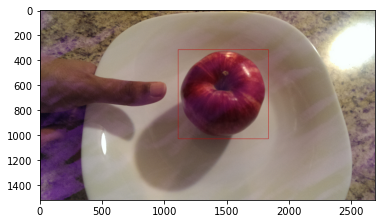

In [8]:
### Display an image and it's bounding box
bb = bounding_boxes[0]
x0=int(w*bb['x'])
x1=int(w*(bb['x'] + bb['w']))
y0=int(h*bb['y'])
y1=int(h*(bb['y'] + bb['h']))
cv2.rectangle(image,(x0,y0),(x1,y1),(200,0,0),2)
imshow(image)

In [9]:
# Displaying method the image gray and large scale
def display_image(img):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

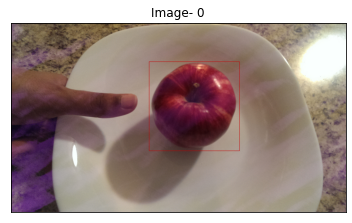

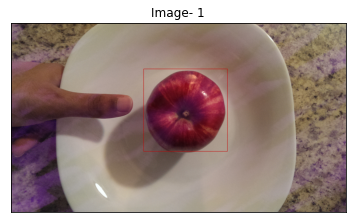

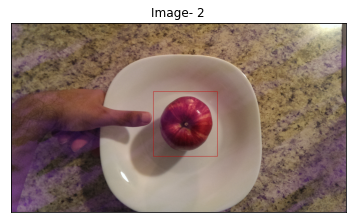

In [12]:
# Displaying first three frames with bounding boxes
for i in range(num_in_sample_boxes):
    bb = bounding_boxes[i]
    x0=int(w*bb['x'])
    x1=int(w*(bb['x'] + bb['w']))
    y0=int(h*bb['y'])
    y1=int(h*(bb['y'] + bb['h']))
    plt.title('Image- {}'.format(i)), plt.xticks([]), plt.yticks([])
    cv2.rectangle(in_sample_images[i],(x0,y0),(x1,y1),(200,0,0),2) 
    plt.imshow(in_sample_images[i],cmap = 'gray')
    plt.show()

## Color Space for Segmentation

HSV domain is a good choice for image segmentation using the color map. R,G,B values are not distributed uniformly and finding color range is not a trivial task using RGB. On the contrary, using HSV enables to see how the colors are distrubuted more accurately. In the latter section, there is a given hsv low and high color ranges, but these ranges don't work for every frame. For this reason, I've created my own two filters,first is used to find correct color range for apples and the second one as performing contour detection and discard outlier regions and finally creating a good mask using morphological operators. I thought to use different color filters and merge them (for example, apple contains not only the red regions, but also stems are brownish and there are light reflections that means white colors are also seen) But this degraded the result as there are lots of color distributions within the images. 

In this work, hsv color space is extracted from apple images to find color filter boundaries by using only apple images! In this way, low and high filter values are chosen sensitively by looking the hsv distribution for only 3 frames (we have only 3 frames as ground truth) I also performed this analysis for cropped apple images to see refined color distributon tailored to apples. One might think of why I haven't used background color distribution, the answer is that I focused on only foreground since background color distributions change drastically from frame to frame.

In [236]:
# First frame RGB to HSV conversion
first_frame = in_sample_images[0]
# Cropping the apples with image boundries 
cropped_image = first_frame[y0:y1,x0:x1]

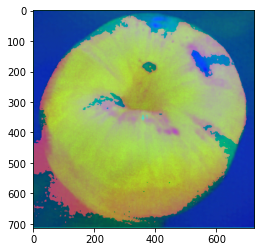

In [244]:
hsv_apple = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2HSV)
plt.imshow(hsv_apple)

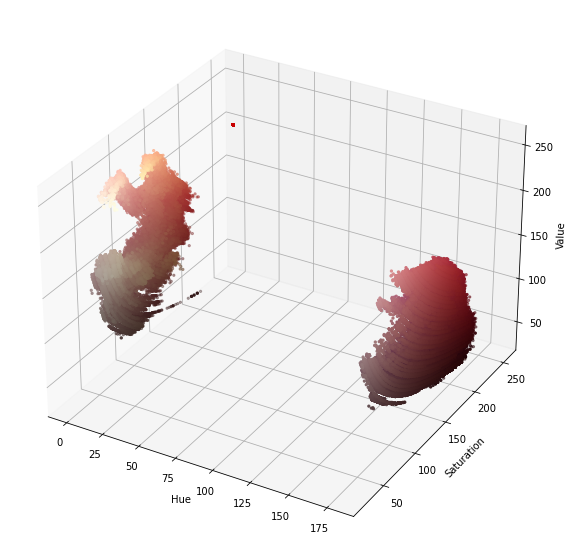

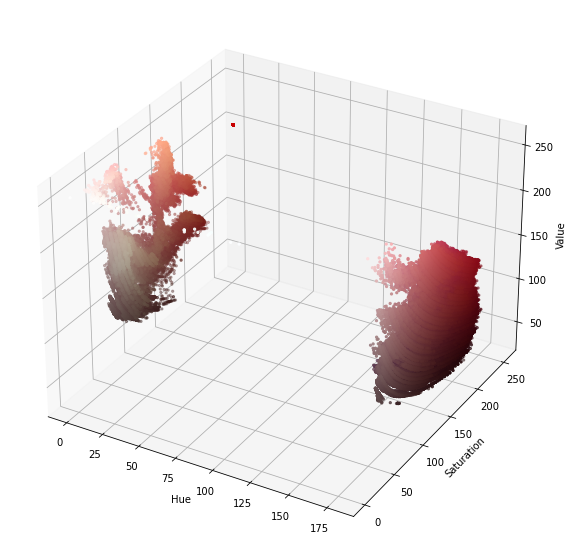

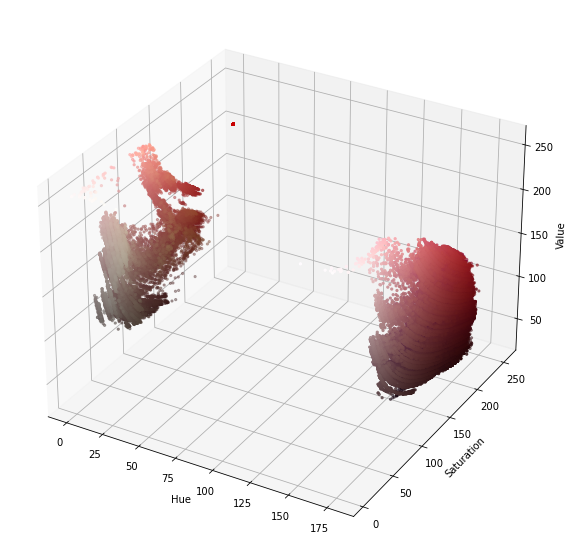

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

for i in range(num_in_sample_boxes):
    # For each in-sample frame, we are extracting apple boundaries
    (h,w)=in_sample_images[i].shape[:2]
    bb = bounding_boxes[i]
    x0=int(w*bb['x'])
    x1=int(w*(bb['x'] + bb['w']))
    y0=int(h*bb['y'])
    y1=int(h*(bb['y'] + bb['h']))
    
    # For each in-sample frame, we are also extracting cropped apple image
    cropped_image = in_sample_images[i][y0:y1,x0:x1]
    # Color conversion to HSV
    hsv_apple = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2HSV)
    # color space extraction
    pixel_colors = cropped_image.reshape((np.shape(cropped_image)[0]*np.shape(cropped_image)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    # Obtaining h,s,v values for each in-sample frame
    h, s, v = cv2.split(hsv_apple)

    fig = plt.figure(figsize=(10,10))
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors = pixel_colors, marker=".")
    axis.set_xlabel("Hue")
    axis.set_ylabel("Saturation")
    axis.set_zlabel("Value")
    plt.show()

As can be seen from the above figures, hsv colors are distributed for darker red regions around (0,160,40) and (250,255,255) for lighter regions. There are lighter white regions but these are light reflections and might be deceptive and was overcome by appropriate morhpological operators in the latter section 

In [33]:
# Frame-1, Frame-2, Frame-3 HSV color range distribution
low_red = (0,160,40)
high_red = (250,255,255)

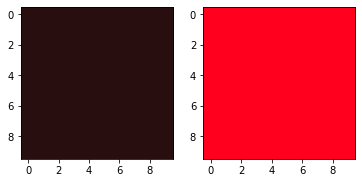

In [34]:
from matplotlib.colors import hsv_to_rgb

lw_square = np.full((10, 10, 3), low_red, dtype=np.uint8) / 255.0
dw_square = np.full((10, 10, 3), high_red, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lw_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(dw_square))
plt.show()


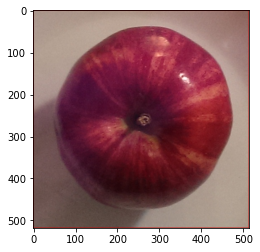

In [35]:
plt.imshow(cropped_image)

### Color segmentation using HSV Boundaries

In this first part of the work, hsv colour boundaries are extracted using first three frames and tested against a out of sample frame

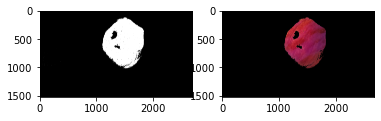

In [41]:
# Picking up a random frame and performing hsv color lower and upper boundaries
test_image = out_sample_images[9]
hsv_apple = cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV)

# creating the mask with low and high boundaries
mask = cv2.inRange(hsv_apple, low_red, high_red)
result = cv2.bitwise_and(test_image,test_image, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

### Outlier Removal using contour detection

In this section, I performed further outlier removal in the second stage and removed the ones having a width and length below than 350. This information is also coming from the ground truth information (box width and length) for the first three frames. However, it can not be generalized to all of the apple images around the world. We assumed here that we have ground truth information and assume that the unknown images are taken in similar conditions. Below code only extracts external contours and fills the holes inside the object, finally leading an appropriate mask

In [43]:
#only grayscaled images can be used for contour detection 
img = cv2.cvtColor(result,cv2.COLOR_RGB2GRAY)

# external contour detection
contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Set up empty array
external_contours = np.zeros(img.shape)

# Every object contour
for i in range(len(contours)):
    
    if cv2.boundingRect(contours[i])[2]>300 and cv2.boundingRect(contours[i])[3]>300:

        # last column in the array is -1 if an external contour (no contours inside of it)
        if h[0][i][3] == -1:
        
            # We can now draw the external contours from the list of contours
            cv2.drawContours(external_contours, contours, i, 255, -1)

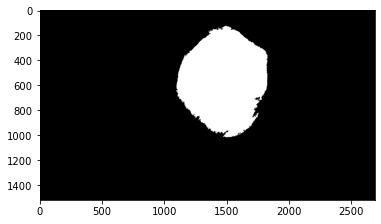

In [44]:
# Finally we have a clear mask for apple
plt.imshow(external_contours,cmap='gray')

### Morphological Operations 
This operator performs dilation given the appropriate kernel size. I've performed this operator to fill the unfilled or remained holes from previous stage and expand the object boundaries for better segmentation 

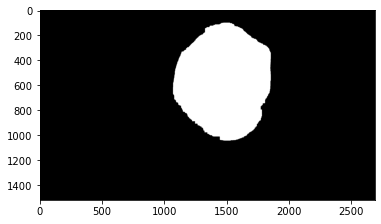

In [47]:
kernel = np.ones((11,11),np.uint8)
dilated_image = cv2.dilate(external_contours,kernel,iterations = 5)

plt.imshow(dilated_image, cmap='gray')

In [50]:
result = cv2.bitwise_and(test_image,test_image, mask=dilated_image.astype(np.uint8))

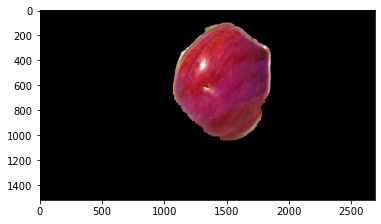

In [51]:
plt.imshow(result)

### Out of Sample Segmentation - Whole code and results

In [59]:
def color_and_contour_filtering(image):
    hsv_apple = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # creating the mask with low and high boundaries
    mask = cv2.inRange(hsv_apple, low_red, high_red)
    result = cv2.bitwise_and(image,image, mask=mask)
    
    #only grayscaled images can be used for contour detection 
    img = cv2.cvtColor(result,cv2.COLOR_RGB2GRAY)

    # external contour detection
    contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Set up empty array
    external_contours = np.zeros(img.shape)

    # Every object contour
    for i in range(len(contours)):
    
        if cv2.boundingRect(contours[i])[2]>350 and cv2.boundingRect(contours[i])[3]>350:

            # last column in the array is -1 if an external contour (no contours inside of it)
            if h[0][i][3] == -1:
        
                # We can now draw the external contours from the list of contours
                cv2.drawContours(external_contours, contours, i, 255, -1)
    
    kernel = np.ones((11,11),np.uint8)
    dilated_image = cv2.dilate(external_contours,kernel,iterations = 5)
    final_result = cv2.bitwise_and(image,image, mask=dilated_image.astype(np.uint8))
    
    return final_result

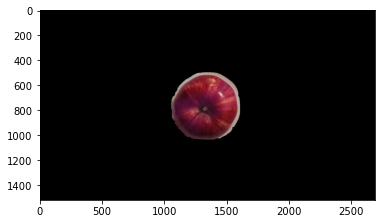

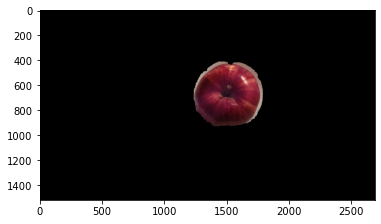

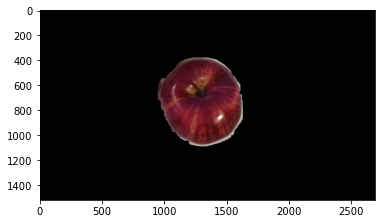

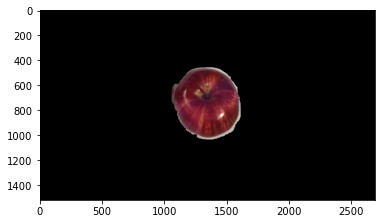

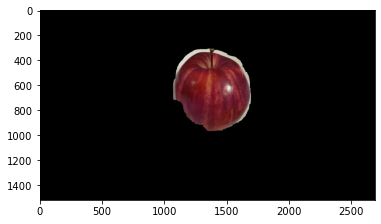

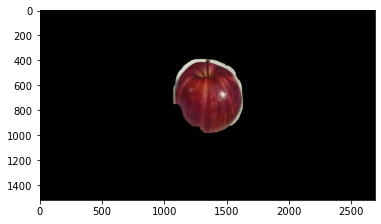

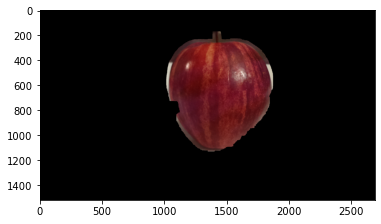

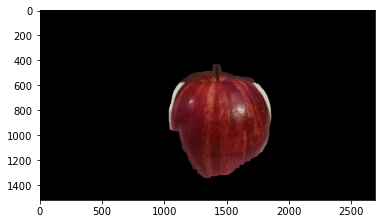

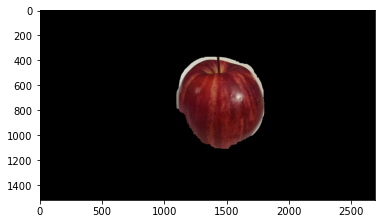

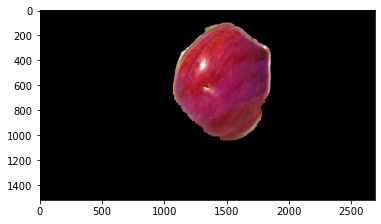

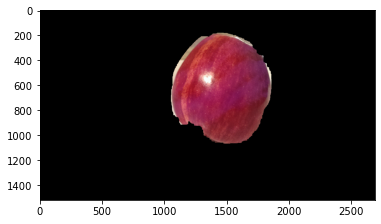

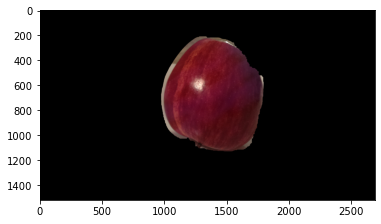

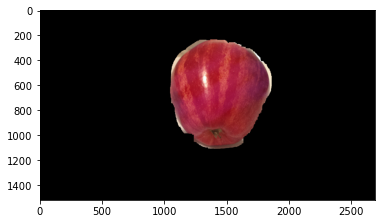

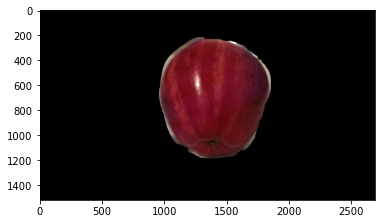

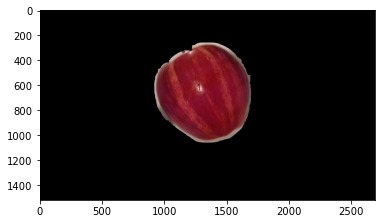

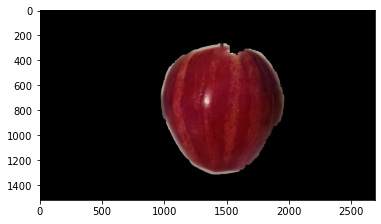

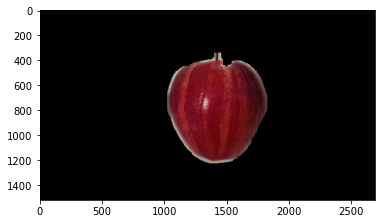

In [60]:
for i in range(len(out_sample_images)):
    result = color_and_contour_filtering(out_sample_images[i])
    plt.imshow(result)
    plt.show()